In [1]:
# Разложение временных рядов

Разложение временных рядов преобразует временной ряд в несколько различных составляющих. Исходный временной ряд часто разбивается на три компонента:

- Сезонный: закономерности, которые повторяются с фиксированным периодом времени.

- Трендоввый: основная тенденция. Это наиболее "медленный" компонент
- Случайный: также называемый «шумом», «нерегулярным» или «остатком». Это остатки исходного временного ряда после удаления сезонных и трендовых рядов./

STL — это универсальный и надежный метод декомпозиции временных рядов. STL — это аббревиатура от «Seasonal and Trend decomposition using Loess». Метод STL был разработан Р.Б. Кливлендом, Кливлендом, МакРаем и Терпеннингом (1990).
Его плюсы:
- Гибкость: STL обладает замечательной адаптивностью, которая позволяет ему обрабатывать данные временных рядов со сложными и постоянно меняющимися шаблонами. В отличие от традиционных методов, STL не ограничивается строгими предположениями о структуре данных.
- Устойчивость: он надежно противостоит натиску выбросов и шума, которые часто портят временные ряды. Даже при наличии аномалий STL остается неизменным, обеспечивая надежные результаты декомпозиции. Смягчая влияние выбросов и шума, STL гарантирует, что основные закономерности не будут затмеваться, что позволяет нам с уверенностью извлекать значимую информацию из данных.
- Настраиваемость: С помощью STL у вас есть возможность контролировать уровень сглаживания, применяемый к трендовым и сезонным компонентам. Такая возможность настройки позволяет вам найти идеальный баланс между сохранением нюансов данных и извлечением ключевых компонентов, которые определяют ваш анализ.
- Простота реализации. В этом мы убедимся на собственном опыте))

С другой стороны, STL имеет некоторые недостатки. В частности, он не обрабатывает автоматически изменения календаря и предоставляет только возможности для аддитивной декомпозиции.

Можно получить мультипликативное разложение, сначала взяв логарифм от данных, а затем выполнив обратное преобразование компонентов. Разложение между аддитивным и мультипликативным может быть получено с помощью преобразования Бокса-Кокса с $ 0 < \lambda < 1 $. Значение $λ=0$ соответствует мультипликативному разложению, а $λ=1$  эквивалентно аддитивному разложению.

Рассмотрим пример применения разложения "из коробки". При этом рассмотрим сразу два варианта: обычный и робастный. В качестве примера рассмотрим данные о потреблении электричества.
При выборе робастного метода используется зависящая от данных весовая функция, которая повторно взвешивает семплы при оценке LOESS (и, следовательно, при использовании LOWESS).

Далее оценим модель с перевзвешиванием и без него. Разница незначительна и наиболее заметна во время финансового кризиса 2008 года. Ненадежная оценка придает одинаковый вес всем наблюдениям и поэтому оставляет в среднем меньшие шумы. Веса варьируются от 0 до 1.


In [110]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from functools import partial
from pandas.plotting import register_matplotlib_converters
from statsmodels.datasets import elec_equip as ds
from statsmodels.tsa.seasonal import STL, DecomposeResult
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import mean_squared_error
from scipy.linalg import qr
from scipy.linalg import solve_triangular

register_matplotlib_converters()
np.random.seed(42)
sns.set_style("darkgrid")

In [66]:
elec_equip = ds.load().data.iloc[:, 0]

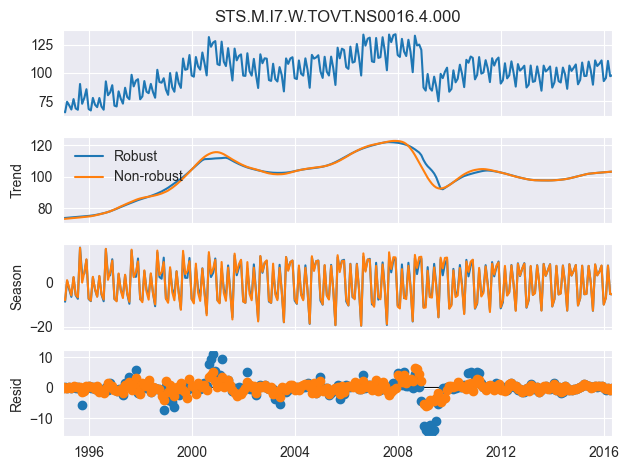

In [3]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

stl = STL(elec_equip, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(elec_equip, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])

In [278]:
def solve(x, y, W, deg: int = 1):

    A = np.vander(x, N=1+deg) # |  X^2 |X | X^0 ... - we construct polynomial features from x

    # x is horizontal, since we need to transpose it to get solution
    V = np.matmul(np.matmul(A.T, W), A)  # (X^T W)^T X
    Y = np.matmul(np.matmul(A.T, W), y)  # ( X^T W ) y
    Q, R = qr(V)  # make triangular from matrix to get easier solution -> (X^T W)^T X = QR -> final equation: R beta = Q^T * ( X^T W ) y makes
    p = solve_triangular(R, np.matmul(Q.T, Y)) # helps to solve equation with triangular left matrix
    return p


In [313]:
def get_span(x: np.array, y: np.array, x_target: float, k: int) -> tuple[np.typing.NDArray, np.typing.NDArray, np.typing.NDArray]:
    """ Returns distances, x in span and y in span.
     x is all the x, x_targte - target x, k - number of neighbours to use
     """
    # get list of distances
    distance = abs(x - x_target)
    # get sorted distances and corresponding indices (using, for example, np.sort + np.argsort)
    sorted_dist = np.sort(distance)
    ind = np.argsort(distance)
    ind_span = ind[:k]
    # we need to use x-s and y-s later in the code, so get them too
    x_span = x[ind_span]
    y_span = y[ind_span]
    # which distance is the biggest?
    delta_0 = sorted_dist[-1]
    # get normalized distances
    u = distance[ind_span] / delta_0
    return u, x_span, y_span, ind_span

In [322]:
def tricub_kernel(dist):
    return (1 - dist**3)**3

def bell_kernel(dist, tau):
    return  np.exp(- dist**2/(2*tau**2))

def loess(x, y, kernel, k, deg, weights=None, **kernel_params):
    y_pred = np.zeros(len(x))
    x_space = np.zeros_like(x)
    for i, x_target in enumerate(x):
        u, x_span, y_span, ind_span = get_span(x, y, x_target, k)
        w = kernel(u, **kernel_params)
        if weights is not None:  
            w *= weights[ind_span]
        W = np.diag(w)
        p = solve(x_span, y_span, W, deg = deg)
        y_pred[i] = np.polyval(p, x_target)
        x_space[i] = x_target
    return y_pred, x_space


def loess_tricub(x, y, k, deg, weights=None):
    return loess(x=x, y=y, kernel=tricub_kernel, k=k, deg=deg, weights=weights)

In [323]:
from random import randrange

x = np.linspace(1, 100, 100)
y = np.array([0.6 * el + 1 * np.sin(el*2) + randrange(10) for el in x])

In [324]:
for i, el in enumerate(y[7:]):
    el += 15 * y[i - 7]
for i, el in enumerate(y[3:]):
    el += 5 * y[i - 3]
for i, el in enumerate(y[30:]):
    el -= 15 * y[i - 30]
for i, el in enumerate(y[10:]):
    el += 10 * y[i - 10]

In [325]:
y_pred, x_pred = loess_tricub(x, y, k=5, deg=1)

error =  6.455105476826577


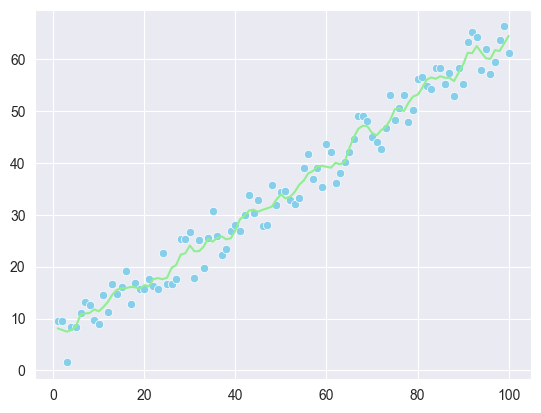

In [326]:
fig = plt.figure()
sns.scatterplot(x=x, y=y, color ='skyblue')
sns.lineplot(x=x_pred, y=y_pred, color ='lightgreen')
print("error = ", mean_squared_error(y_true=y, y_pred=y_pred))

Используем для лоесса полиномы степени d. Число n задает число соседей для рассчета весов.

STL состоит из двух циклов: внутреннеего и внешнего.
Во внутреннем трендовая и сезонная компоненты обновляются, эта процедура повторяется $n_{(i)}$ раз.
Каждй прогон внешнего цикла состоит из прогона внутреннего и дальнейшего пересчета робастных весов.В первой итерации внешнего цикла все веса равны 1, после чего делается  $n_{(о)}$ таких прогонов.

Пусть цикл сезонной компоненты равен $n_{(p)}$. Нам необходимо получить все срезы временного ряда для каждого сезона. Так, например, первый срез для цикла размера 12 для данных по дням будет давать все январские значения.

Внутренний цикл:
1) Детрендинг: X - T
2) Каждый срез сезона сглаживается лоессом с $n_{(s)}$ и d=1.
3) Фильтр. Он состоит из последовательного применения MA с параметром  $n_{(p)}$, после его применяется лоесс с $n_{(l)}$ и d=1
4) Детрендинг циклической составляющей. Сезонная составляющая на (k+1) шаге равна $ C_v^{k+1} - L_v^{k+1}, v=1,N$
5) Вычитание сезонности: X - C
6) Сглаживание тренда. После вычитания сезонности ряд сглаживается лоессом с $n_{(t)}$ и d=1. На k+1 итерации $T^{k+1}$ задается этими значениями.

При этом $T_v^0 = 0$

Внешний цикл. Рассмотрим остатки: R = X - T - C. Проведем переввешивание семплов на основе остатков в соответствии с робастным лоессом.



Итого, у STL 6 параметров:
1) $n_p$ - число наблюдений в каждом сезонном срезе
2) $n_i$ - число проходов через внутренний цикл (чаще всего 1 или 2)
3) $n_o$ - число проходов через внешний цикл (0 - если остатки гауссовы)
1) $n_l$ - параметр фильтра: наименьшее нечетное число, большее или равное $n_p$
2) $n_t$ - параметр сглаживания для тренда ($[1.5 * n_p / (1 - 1.5/n_s)]_{odd} $
3) $n_s$ - параметр сглаживания для сезонности (больше или равно 7, но вообще зависит от примера)

Для начала реализуем упрощенную версию, без внешнего цикла. 

In [320]:

def decompose(x, y, period: int = 365, loess_frac: float = 0.05, inner_iter = 2):
    """
    Returns:
        `statsmodels.tsa.seasonal.DecomposeResult`: An object with DataFrame attributes for the
            seasonal, trend, and residual components, as well as the average seasonal cycle.

    """
    trend_part = np.zeros_like(y)
    seasonal_part = np.zeros_like(y)
    residuals = np.zeros_like(y)

    # period must not be larger than size of series to avoid introducing NaNs
    period = min(period, len(y))
    cyclic_collection = np.zeros_like(y)
    for _ in range(inner_iter):
        # Step 1. Detrending
        detrended = y - trend_part
        # Step 2. Cyclic collection smoothing
        n_s = max(int(loess_frac * len(y) // period), 7) # 7 is from original paper
        for start in range(0, period):  
            cycle = detrended[start::period]
            smoothed_cycle, x_space = loess_tricub(
                x = np.linspace(0., len(cycle)-1, (len(cycle)), dtype=float), 
                y = cycle,
                k = n_s,
                deg = 1 
            )
            cyclic_collection[start::period] = smoothed_cycle
        # Step 3. Low-pass filter
        n_l = period if period % 2 else period + 1  # from article
        low_pass = uniform_filter1d(uniform_filter1d(cyclic_collection, size=period), size=period)
        low_pass = uniform_filter1d(low_pass, size=3)
        smoothed_seasons, x_space = loess_tricub(
                x = np.linspace(0., len(low_pass)-1, (len(low_pass)), dtype=float),
                y = low_pass,
                k = n_l,
                deg = 1
            )
        # Step 4. Seasonal component
        seasonal_part = cyclic_collection - smoothed_seasons
        # Step 5. Deseasonong
        deseasoned = y - seasonal_part

        # Step 6. Trend
        n_t = int(1.5 * period / (1 - 1.5 / n_s)) # formula is from article
        trend_part, x_space = loess_tricub(
                        y = deseasoned,
                        x = np.linspace(0., len(deseasoned)-1, (len(deseasoned)), dtype=float),
                        k = n_t,
                        deg = 1
                    )

        residuals = y - trend_part - seasonal_part

    # convert the arrays back to appropriate dataframes, stuff them back into
    #  the statsmodel object
    results = list([seasonal_part, trend_part, residuals, y])
    dr = DecomposeResult(seasonal=results[0],
                         trend=results[1],
                         resid=results[2],
                         observed=results[3])
    return dr

In [ ]:
Проверим результат. Для более объективной оценки построим график и для разложения из statsmodels. 

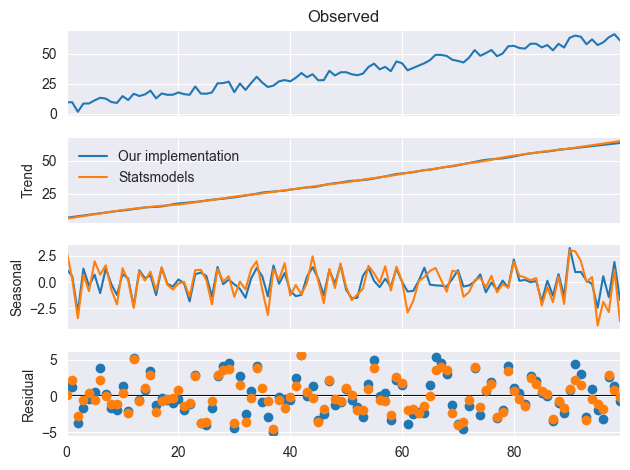

In [332]:
dec = decompose(x, y, 10, 0.1, inner_iter=5)
fig = dec.plot()
stl = STL(pd.DataFrame(y, index=x-1), period=10, robust=False) # fix to get parallel representation
res_robust_lib = stl.fit()
add_stl_plot(fig, res_robust_lib, ["Our implementation", "Statsmodels"])

Как видно, результаты достаточно близки. Наша реализация довольно наивна, так что детали решений могут отличаться.

Теперь реализуем метод с учетом внешнего цикла - robust STL. Мы уже учли возможность в LOESS добавить вес семплов в рассчет расстояний. Поэтому остается только реализовать внешний цикл и немного адаптировать внутренний. 

In [349]:
def stl_inner_loop(x, y, period: int = 365, loess_frac: float = 0.05, inner_iter = 2, weights = None):
    trend_part = np.zeros_like(y)
    seasonal_part = np.zeros_like(y)
    residuals = np.zeros_like(y)
    
    # period must not be larger than size of series to avoid introducing NaNs
    period = min(period, len(y))
    cyclic_collection = np.zeros_like(y)
    
    for _ in range(inner_iter):
        # Step 1. Detrending
        detrended = y - trend_part
        # Step 2. Cyclic collection smoothing
        
        n_s = max(int(loess_frac * len(y) // period), 7)  # 7 is from original paper
        for start in range(0, period):  
            cycle = detrended[start::period]
            cycle_weights = weights[start::period] if weights is not None else None
            smoothed_cycle, x_space = loess_tricub(
                x = np.linspace(0., len(cycle)-1, (len(cycle)), dtype=float), 
                y = cycle,
                k = n_s,
                deg=1,
                weights=cycle_weights
            )
            cyclic_collection[start::period] = smoothed_cycle
            
        # Step 3. Low-pass filter
        n_l = period if period % 2 else period + 1  # from article
        low_pass = uniform_filter1d(uniform_filter1d(cyclic_collection, size=period), size=period)
        low_pass = uniform_filter1d(low_pass, size=3)
        smoothed_seasons, x_space = loess_tricub(
                x = np.linspace(0., len(low_pass)-1, (len(low_pass)), dtype=float),
                y = low_pass,
                k = n_l,
                deg=1
            )
        # Step 4. Seasonal component
        seasonal_part = cyclic_collection - smoothed_seasons
        # Step 5. Deseasonong
        deseasoned = y - seasonal_part

        # Step 6. Trend
        n_t = int(1.5 * period / (1 - 1.5 / n_s)) # formula is from article
        trend_part, x_space = loess_tricub(
                        y = deseasoned,
                        x = np.linspace(0., len(deseasoned)-1, (len(deseasoned)), dtype=float),
                        k=n_t,
                        deg=1,
                        weights=weights
                    )

        residuals = y - trend_part - seasonal_part
    return trend_part, seasonal_part, residuals

Для того, чтобы сделать метод более робастным, используем робастный LOESS.

Определим остатки:
\begin{equation}
r_i = y_i - f (x_i)
\end{equation}

Тогда мы можем применить биквадратное ядро для перевзвешивания.
\begin{equation}
    B(u, b) =
    \begin{cases}
      (1 - u^2)^2, & 0 \leq u < 1 \\
      0, & \text{otherwise}
    \end{cases}
\end{equation}
Пусть $m(r) = median(|r|)$. Дополнительные веса тогда:
\begin{equation}
\gamma_i = B(r_i / 6m)
\end{equation}

Финальные веса принимают вид $\tilde {w_i } = \gamma_i * w_i $.



In [350]:
def bicubic(u): 
    mask = np.logical_and(u > 0, u < 1).astype(float)
    return (1 - u**2)**2 * mask
    
def robust_stl(x, y, period: int = 365, loess_frac: float = 0.05, inner_iter: int = 2, outer_iter: int = 2):
    weights = np.ones_like(y)
    for _ in range(outer_iter):
        trend_part, seasonal_part, residuals = stl_inner_loop(
            x=x, y=y, weights=weights, period=period, loess_frac=loess_frac, inner_iter=inner_iter
        )
        h = 6 * np.median(np.abs(residuals))
        weights = bicubic(residuals / h)
    results = list([seasonal_part, trend_part, residuals, y])
    dr = DecomposeResult(seasonal=results[0],
                         trend=results[1],
                         resid=results[2],
                         observed=results[3])
    return dr

In [354]:
#dec_non_robust = decompose(x, y, 10, 0.1)
#fig = dec_non_robust.plot()
dec = robust_stl(x, y, 10, 0.1, inner_iter = 5, outer_iter = 2)
add_stl_plot(fig, dec, ["Non_robust", "Robust"])

Проверим наши методы на реальных данных.

In [232]:
elec_equip = ds.load().data.iloc[:, 0]
x = np.linspace(0., len(elec_equip)-1, len(elec_equip))
y = elec_equip.values

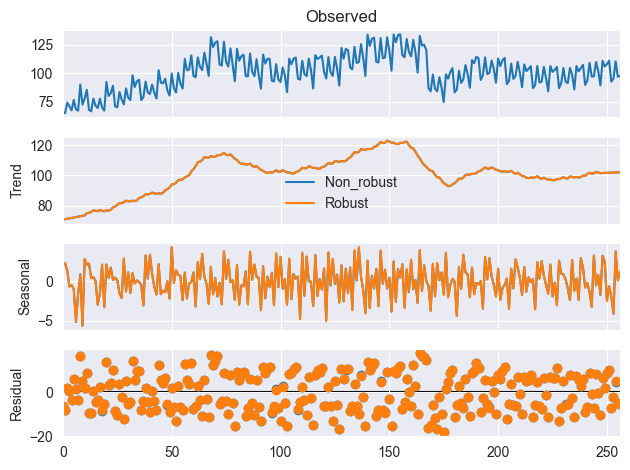

In [233]:
dec_non_robust = decompose(x, y, 10, 0.1)
fig = dec_non_robust.plot()
dec = robust_stl(x, y, 10, 0.1, inner_iter = 5, outer_iter= 5)
dec = robust_stl(x, y, 10, 0.1)
add_stl_plot(fig, dec, ["Non_robust", "Robust"])

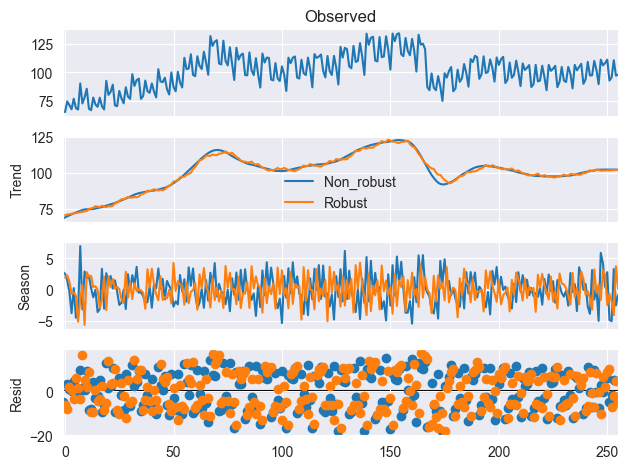

In [234]:
stl = STL(pd.DataFrame(y, index=x-1), period=10, robust=False) # fix to get parallel representation
dec_non_robust = stl.fit()
fig = dec_non_robust.plot()
stl = STL(pd.DataFrame(y, index=x-1), period=10) # fix to get parallel representation
res_robust = stl.fit()

dec = robust_stl(x, y, 10, 0.1)
add_stl_plot(fig, dec, ["Non_robust", "Robust"])